In [3]:
# Dependencies

# Basics
import os
import sys
import time
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from collections import defaultdict
import os

from config import recent_play_by_play, recent_clean_db, last_game_date, tourney_bubble


In [4]:
## File Paths
folder_prefix = ''

data_folder = os.path.join(folder_prefix, '..', 'data/') # Data Folder Path
temp_folder = os.path.join(folder_prefix,'..', 'TEMP/',) # Temp Folder Path
image_folder = os.path.join(folder_prefix, '..', 'images/') # Image Folder Path
logo_folder = os.path.join(folder_prefix, image_folder, 'logos/') # Logo Folder Path
conference_logo_folder = os.path.join(folder_prefix, logo_folder, 'conference') # Conference Logo Folder Path
export_folder = os.path.join(folder_prefix, image_folder, 'export/') # Export Folder Path
background_folder = os.path.join(folder_prefix, image_folder, 'background/') # Background Folder Path

# Other paths
school_info_path = os.path.join(data_folder, 'arena_school_info.csv') # School Info Path

#### Database connection and extract 

In [5]:
## Load the database
conn = sqlite3.connect(recent_clean_db, isolation_level=None)

## Extract player_stats and convert TOI into seconds for easier calculations
player_stats = pd.read_sql_query("SELECT * FROM player_stats", conn)

### TOI to seconds - From MM:SS string to seconds integer
def convert_toi_to_seconds(toi_str):
    if pd.isna(toi_str):
        return None
    try:
        minutes, seconds = map(int, toi_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        return None

player_stats['TOI'] = player_stats['TOI'].apply(convert_toi_to_seconds)

# Check Data
print(player_stats.head())


             Team           Player  G  A Pts plus_minus Sh     TOI PIM  FOW  \
0  Michigan State     Isaac Howard  1  1   2          2  5  1034.0   0  NaN   
1  Michigan State   Daniel Russell  1  1   2          2  5  1140.0   0  0.0   
2  Michigan State    Nathan Mackie  0  0   0          0  1   414.0   2  2.0   
3  Michigan State   Shane Vansaghi  0  0   0          0  0   580.0   0  NaN   
4  Michigan State  Gavin O'Connell  0  0   0         -1  2   948.0   0  NaN   

   FOL   FO%                                  Game_ID  
0  NaN   NaN  2024-10-04-Michigan State-Lake Superior  
1  1.0   0.0  2024-10-04-Michigan State-Lake Superior  
2  3.0  40.0  2024-10-04-Michigan State-Lake Superior  
3  NaN   NaN  2024-10-04-Michigan State-Lake Superior  
4  NaN   NaN  2024-10-04-Michigan State-Lake Superior  


In [6]:
#### Create a date column for each row based on the Game_ID to track change in ice time over the season
def get_date_from_game_id(game_id):
    if pd.isna(game_id):
        return None
    try:
        return str(game_id)[:10]

        # Convert to datetime object
        date_obj = datetime.strptime(game_id, '%Y-%m-%d')
        # Convert to desired format
        

    except ValueError:
        return None

# Create a new column 'Date' in the DataFrame
player_stats['Date'] = player_stats['Game_ID'].apply(get_date_from_game_id)

# Check Data
print(player_stats.head())

             Team           Player  G  A Pts plus_minus Sh     TOI PIM  FOW  \
0  Michigan State     Isaac Howard  1  1   2          2  5  1034.0   0  NaN   
1  Michigan State   Daniel Russell  1  1   2          2  5  1140.0   0  0.0   
2  Michigan State    Nathan Mackie  0  0   0          0  1   414.0   2  2.0   
3  Michigan State   Shane Vansaghi  0  0   0          0  0   580.0   0  NaN   
4  Michigan State  Gavin O'Connell  0  0   0         -1  2   948.0   0  NaN   

   FOL   FO%                                  Game_ID        Date  
0  NaN   NaN  2024-10-04-Michigan State-Lake Superior  2024-10-04  
1  1.0   0.0  2024-10-04-Michigan State-Lake Superior  2024-10-04  
2  3.0  40.0  2024-10-04-Michigan State-Lake Superior  2024-10-04  
3  NaN   NaN  2024-10-04-Michigan State-Lake Superior  2024-10-04  
4  NaN   NaN  2024-10-04-Michigan State-Lake Superior  2024-10-04  


## Time On Ice Exploration

- WANT TO DO
    - Get Line and position for each player for each game - link by game_id can also pull in shot and whatever other data might want (blocked shots)

In [7]:
### Call the line_chart db table to the a dataframe
line_chart = pd.read_sql_query("SELECT * FROM line_chart", conn)

# Group into F / D / G lines based on Position column into new pos_1 / pos_2 columns
# # pos_1 = F / D / G 
# Center, Left Wing, Right Wing = F
# left D, Right D = D
# Goalie = G

# pos_2 = C / L / R / D / G


## Assign positions in the new columns
def assign_positions(row):
    if row['Position'] in ['Center', 'Left Wing', 'Right Wing']:
        return pd.Series(['F', row['Position'][0]])
    elif row['Position'] in ['Left D', 'Right D']:
        return pd.Series(['D', 'D'])
    elif row['Position'] == 'Goalie':
        return pd.Series(['G', 'G'])
    else:
        return pd.Series([None, None])
line_chart[['pos_1', 'pos_2']] = line_chart.apply(assign_positions, axis=1)

# Check Data
# print(line_chart.head(20))



In [8]:
#### Merge Position Data in with the player_stats dataframe based on Team, Player, and Game_ID

merged_df = pd.merge(player_stats, line_chart[['Game_ID', 'Team', 'Player', 'Line', 'pos_1', 'pos_2']], on=['Game_ID', 'Team', 'Player'], how='left')

# Relabel the rows of extra skaters - they have NaN in Line pos1 / pos_2 columns - Replace with 'E'
# merged_df.loc[merged_df['pos_1'].isna(), 'pos_1'] = 'E'
# merged_df.loc[merged_df['pos_2'].isna(), 'pos_2'] = 'E'
merged_df['pos_1'].fillna('E', inplace=True)
merged_df['pos_2'].fillna('E', inplace=True)
merged_df['Line'].fillna('E', inplace=True)

# Remove any rows with TOI = 0
merged_df = merged_df[merged_df['TOI'] != 0]
# Convert to minutes
merged_df['TOI'] = merged_df['TOI'] / 60

# Check Data
# merged_df.head(20)

C:\Users\jbanc\AppData\Local\Temp\ipykernel_2316\3266563582.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['pos_1'].fillna('E', inplace=True)
C:\Users\jbanc\AppData\Local\Temp\ipykernel_2316\3266563582.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [9]:
# ### Some Basic statitical exploration

# # ### Calculate mean and median TOI for forwards and defense by team
# def calculate_mean_median_toi(player_stats):
#     # Group by team and position
#     grouped = player_stats.groupby(['Team', 'pos_1'])

#     # Calculate mean and median TOI
#     mean_toi = grouped['TOI'].mean()
#     median_toi = grouped['TOI'].median()

#     return pd.DataFrame({'Mean_TOI': mean_toi, 'Median_TOI': median_toi}).reset_index()

# mean_median_df = calculate_mean_median_toi(merged_df)

# # Drop G rows
# mean_median_df = mean_median_df[mean_median_df['pos_1'] != 'G']


# # Check Data
# mean_median_df.head()
# mean_median_df.tail()
# # mean_median_df.info()
# # mean_median_df.describe()

### Calculate mean, median based on Line and Position

In [10]:
# #### Get the mean and median TOI for each team grouped by line and pos_1

# def calculate_mean_median_toi_by_line(player_stats):
#     # Group by team, line, and position
#     grouped = player_stats.groupby(['Team', 'Line', 'pos_1'])

#     # Calculate mean and median TOI
#     mean_toi = grouped['TOI'].mean()
#     median_toi = grouped['TOI'].median()

#     return pd.DataFrame({'Mean_TOI': mean_toi, 'Median_TOI': median_toi}).reset_index()

# mean_median_by_line_df = calculate_mean_median_toi_by_line(merged_df)

# # Drop G rows
# mean_median_by_line_df = mean_median_by_line_df[mean_median_by_line_df['pos_1'] != 'G']

# # Check Data
# mean_median_by_line_df.head()

# # Info
# # mean_median_by_line_df.info()

# # 

#### Quick Histogram off TOI by F / D

c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\d

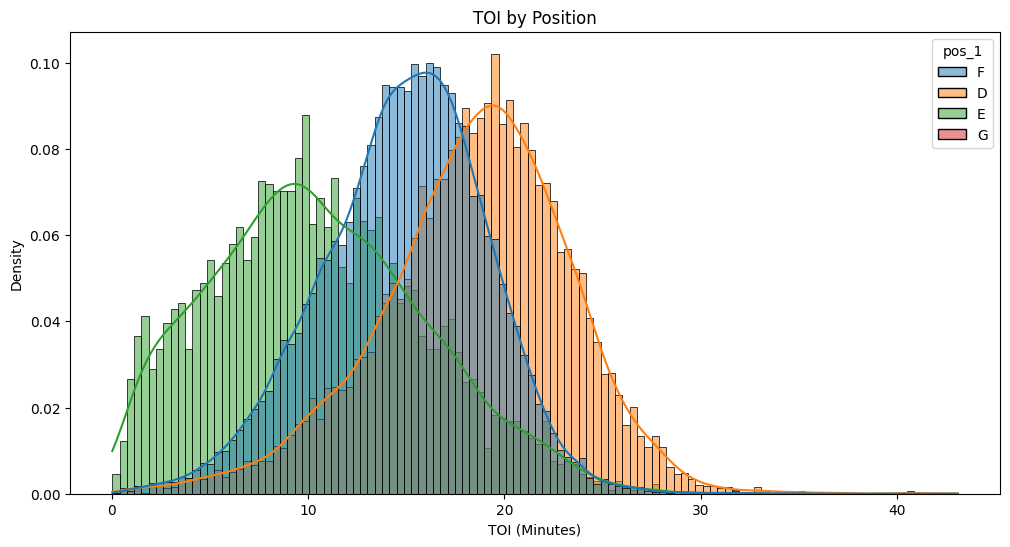

In [11]:
### Eaxamine the data with hisotgrams of TOI by position
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 6))
# Create a histogram for TOI by position
sns.histplot(data=merged_df, x='TOI', hue='pos_1', kde=True, stat='density', common_norm=False)
# Set the title and labels
plt.title('TOI by Position')
plt.xlabel('TOI (Minutes)')
plt.ylabel('Density')
# Show the plot
plt.show()


#### Quick Hosoptgram of TOI Forwards Only on Line assignment

c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\d

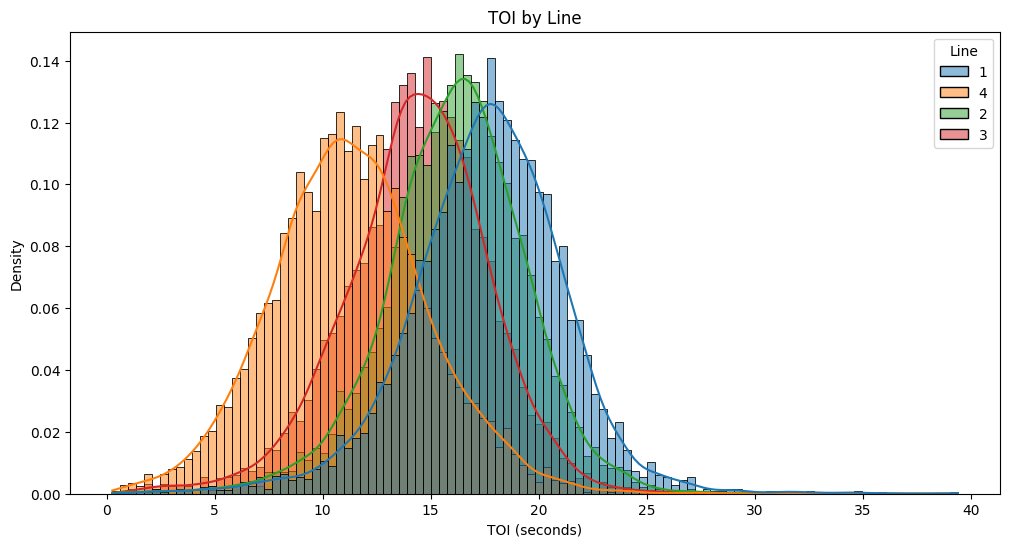

In [12]:
### Same thing by line - only forwards

# Set the figure size
plt.figure(figsize=(12, 6))
# Create a histogram for TOI by position
sns.histplot(data=merged_df[merged_df['pos_1'] == 'F'], x='TOI', hue='Line', kde=True, stat='density', common_norm=False)
# Set the title and labels
plt.title('TOI by Line')
plt.xlabel('TOI (seconds)')
plt.ylabel('Density')
# Show the plot
plt.show()
# Set the figure size

In [13]:
## Print selection of mean and median TOI by line and position
# print(mean_median_by_line_df.head(20))
# print(mean_median_by_line_df.tail(20))

In [14]:
### Create a plot of TOI for Michigan State fowards over time grouped by line #
set_team = 'Michigan State'
# set_team = 'Michigan'
set_team = 'Minnesota'
# set_team = 'Brown'
# set_team = 'Penn State'
# set_team = 'Western Michigan'
# set_team = 'Ohio State'
set_team = 'Wisconsin'


# # Set the figure size
plt.figure(figsize=(10, 10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

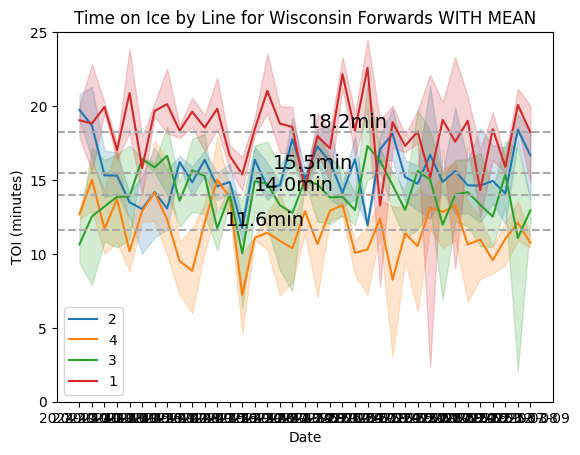

In [15]:
# Get x and y min and max values for the plot
x_min = merged_df['Date'].min()
x_max = merged_df['Date'].max()
y_min = merged_df['TOI'].min()
y_max = merged_df['TOI'].max()

# Set static y axis limits
plt.ylim(0, 25)
# plt.xlim(x_min, x_max)

# Create a line plot for TOI over time for Michigan State forwards
for line in merged_df[(merged_df['pos_1'] == 'F') & (merged_df['Team'] == set_team)]['Line'].unique():
    sns.lineplot(data=merged_df[(merged_df['pos_1'] == 'F') & (merged_df['Team'] == set_team) & (merged_df['Line'] == line)], x='Date', y='TOI', label=line)

for line in merged_df[(merged_df['pos_1'] == 'F') & (merged_df['Team'] == set_team)]['Line'].unique():
    mean_toi = merged_df[(merged_df['pos_1'] == 'F') & 
                           (merged_df['Team'] == set_team) & 
                           (merged_df['Line'] == line)]['TOI'].mean()
    plt.axhline(y=mean_toi, color='darkgray', linestyle='--')

    # Adjust annotation:
    plt.annotate(
        f'{mean_toi:.1f}min',  # Updated text including the line number
        # f'Line {line}: {mean_toi:.1f}m',  # Updated text including the line number
        xy=(1, mean_toi),              # Point on the line (in data coords)
        xycoords='data',
        xytext=(mean_toi, mean_toi),        # Move text further to the right
        textcoords='data',               # Keep using data coordinates
        va='bottom',                     # Vertically center the text on the line
        ha='left',                       # Align text to the left (so it starts where specified)
        # arrowprops=dict(arrowstyle='->', color='red'),
        fontsize=14,
        color='black',
        clip_on=False                   # Allow text to be drawn outside the axes
    )


# Set the title and labels
plt.title(f'Time on Ice by Line for {set_team} Forwards WITH MEAN')
plt.xlabel('Date')
# Convert the tick marks on the y axis into minutes (divide by 60)
plt.ylabel('TOI (minutes)')




# plt.ylabel('TOI (seconds)')
# Show the plot
plt.show()
# Set the figure size




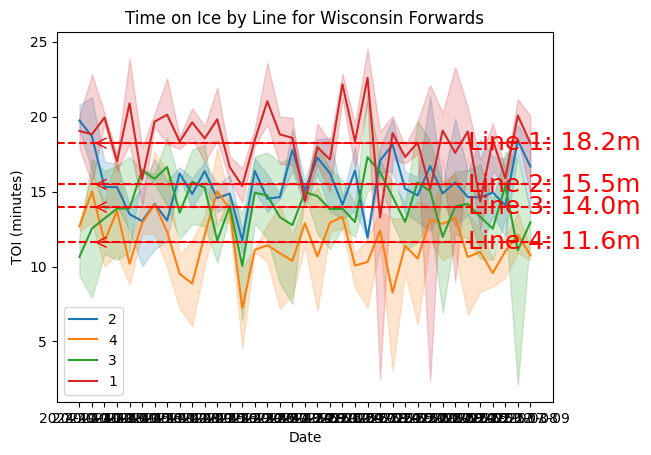

In [16]:


# Convert TOI column from seconds to minutes
# merged_df['TOI'] = merged_df['TOI'] / 60

# Get x and y min and max values for the plot
x_min = merged_df['Date'].min()
x_max = merged_df['Date'].max()
y_min = merged_df['TOI'].min()
y_max = merged_df['TOI'].max()

# Create a line plot for TOI over time for Michigan State forwards
for line in merged_df[(merged_df['pos_1'] == 'F') & (merged_df['Team'] == set_team)]['Line'].unique():
    sns.lineplot(data=merged_df[(merged_df['pos_1'] == 'F') & (merged_df['Team'] == set_team) & (merged_df['Line'] == line)], x='Date', y='TOI', label=line)

for line in merged_df[(merged_df['pos_1'] == 'F') & (merged_df['Team'] == set_team)]['Line'].unique():
    median_toi = merged_df[(merged_df['pos_1'] == 'F') & 
                           (merged_df['Team'] == set_team) & 
                           (merged_df['Line'] == line)]['TOI'].mean()
    plt.axhline(y=median_toi, color='red', linestyle='--')

    # Adjust annotation:
    plt.annotate(
        f'Line {line}: {median_toi:.1f}m',  # Updated text including the line number
        xy=(1, median_toi),              # Point on the line (in data coords)
        xycoords='data',
        xytext=(31.05, median_toi),        # Move text further to the right
        textcoords='data',               # Keep using data coordinates
        va='center',                     # Vertically center the text on the line
        ha='left',                       # Align text to the left (so it starts where specified)
        arrowprops=dict(arrowstyle='->', color='red'),
        fontsize=18,
        color='red',
        clip_on=False                   # Allow text to be drawn outside the axes
    )


# Set the title and labels
plt.title(f'Time on Ice by Line for {set_team} Forwards')
plt.xlabel('Date')
# Convert the tick marks on the y axis into minutes (divide by 60)
plt.ylabel('TOI (minutes)')




# plt.ylabel('TOI (seconds)')
# Show the plot
plt.show()
# Set the figure size




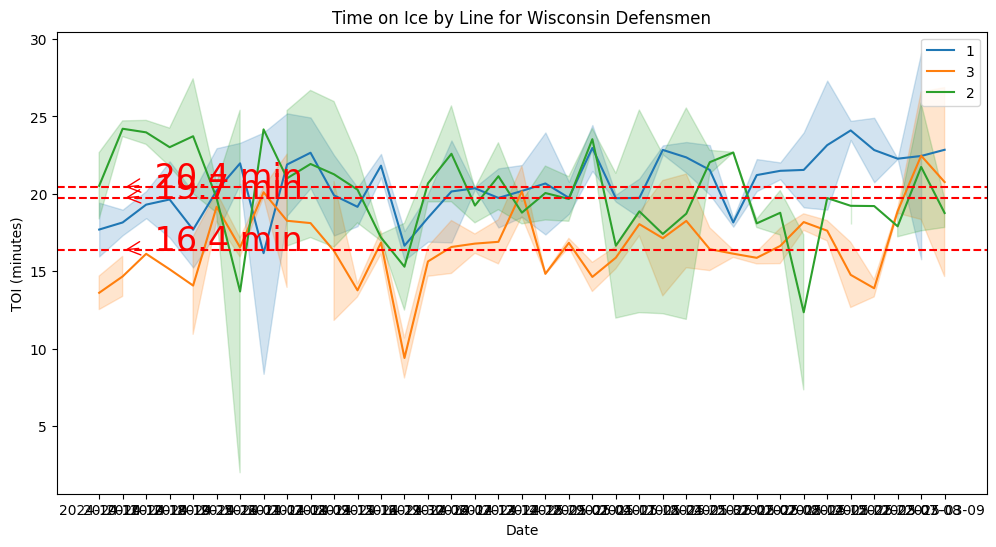

In [17]:
#### Defensive pairs time on ice Plot
# Set the figure size
plt.figure(figsize=(12, 6))

# Convert TOI column from seconds to minutes
# merged_df['TOI'] = merged_df['TOI'] / 60
# Create a line plot for TOI over time for Michigan State defensmen
for line in merged_df[(merged_df['pos_1'] == 'D') & (merged_df['Team'] == set_team)]['Line'].unique():
    sns.lineplot(data=merged_df[(merged_df['pos_1'] == 'D') & (merged_df['Team'] == set_team) & (merged_df['Line'] == line)], x='Date', y='TOI', label=line)

# Add a dashed horizontal line at the median toi for each line
for line in merged_df[(merged_df['pos_1'] == 'D') & (merged_df['Team'] == set_team)]['Line'].unique():
    median_toi = merged_df[(merged_df['pos_1'] == 'D') & (merged_df['Team'] == set_team) & (merged_df['Line'] == line)]['TOI'].median()
    plt.axhline(y=median_toi, color='r', linestyle='--', label=f'Median TOI for {line}')
    # Add Annotation for the median line on the right side of the plot
    plt.annotate(f' {median_toi:.1f} min', xy=(1, median_toi), xytext=(1.92, median_toi),
                 arrowprops=dict(arrowstyle='->', color='red'), fontsize=24, color='red')

# Add light verticle lines for seperating the months


# Set the title and labels
plt.title(f'Time on Ice by Line for {set_team} Defensmen')
plt.xlabel('Date')
# Convert the tick marks on the y axis into minutes (divide by 60)
plt.ylabel('TOI (minutes)')
# Show the plot
plt.show()


In [18]:
## Find the top 5 players in ice time per game. Create seperate tables for forwards and defensmen
## Use the player_stats_ytd table to get the total TOI and Games played
def find_top_players(player_stats, pos_1):
    # Filter the DataFrame for the specified position
    filtered_df = player_stats[player_stats['pos_1'] == pos_1]

    # Group by Player and calculate total TOI and Games Played
    grouped_df = filtered_df.groupby(['Player', 'Team']).agg({'TOI': 'sum', 'Game_ID': 'count'}).reset_index()

    # Calculate TOI per game
    grouped_df['TOI_per_game'] = grouped_df['TOI'] / grouped_df['Game_ID']

    # Sort by TOI per game in descending order and get the top 5 players
    top_players = grouped_df.sort_values(by='TOI_per_game', ascending=False).head(10)

    return top_players
    

top_forwards = find_top_players(merged_df, 'F')
top_defensemen = find_top_players(merged_df, 'D')

# Check Data
print("Top 5 Forwards by TOI per game:")
print(top_forwards)

print("\nTop 5 Defensemen by TOI per game:")
print(top_defensemen)

Top 5 Forwards by TOI per game:
             Player              Team         TOI  Game_ID  TOI_per_game
674       Max Scott             Brown  756.433333       32     23.638542
968     Tyler Kopff             Brown  752.800000       32     23.525000
156        Cam Lund      Northeastern  810.566667       36     22.515741
613    Lucas Wahlin         St Thomas  808.050000       36     22.445833
433   Jack Williams      Northeastern  794.166667       36     22.060185
283   Dominic James  Minnesota Duluth  478.516667       22     21.750758
320      Ethan Leyh           Bentley  737.933333       34     21.703922
596  Liam Malmquist         St Thomas  780.666667       36     21.685185
873       Shane Ott           Niagara  758.650000       35     21.675714
268    David Jacobs         Princeton  514.483333       24     21.436806

Top 5 Defensemen by TOI per game:
                     Player           Team         TOI  Game_ID  TOI_per_game
527           Vinny Borgesi   Northeastern  857.8333